# Jane Street Puzzle 03-2024: Hooks 10

In [1]:
import numpy as np
import z3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage as ndi

### Note

I'm not really satisfied by how long this solution takes to get but it's the script I used to get the result so I'll just leave it as is. There is a small chance I'll optimize the code in the future.

I took inspiration from [this repo](https://github.com/miguelbper/jane-street-puzzles) to get my solution.

## Computational Implementation

In [2]:
hints = np.array([[0, -1, -1, -1, -1], 
                  [-1, -1, 9, -1, 7],
                  [8, -1, -1, -1, -1],
                  [-1, -1, 15, -1, 12],
                  [10, -1, -1, -1, -1]])

def areas(grid):
    labels, num = ndi.label(np.logical_not(grid != 0))
    areas = ndi.sum(np.logical_not(grid != 0), labels, index=range(1, num + 1))
    print("areas are", areas)
    return np.prod(areas)

def neigh(i, j, n):
    return [(i + x, j + y) for (x, y) in [(-1, 0), (1, 0), (0, -1), (0, 1)]
            if 0 <= i + x < n and 0 <= j + y < n]

def create_L(n):
    arr = []
    for i in range(n - 1):
        aux = [1]
        for j in range(n - 1):
            aux.append(0)
        arr.append(aux)
    arr.append(np.ones(n))

    return np.array(arr, dtype=int)
        

In [3]:
def fill(hints, n, tactic="qffd"):
    # set up the variables
    scores = np.array(z3.IntVector("scores", n * n), dtype=object).reshape(n, n)
    region = np.array(z3.IntVector("region", n * n), dtype=object).reshape(n, n)

    # set up solver

    s = z3.Tactic(tactic).solver()

    # bounds for the values
    s += [z3.And(e >= 0, e <= n) for (i,j), e in np.ndenumerate(scores)]

    # if hints has a value, then scores has to be 0
    s += [scores[i][j] == 0 for (i, j), e in np.ndenumerate(hints) if e != -1]

    # cells orthogonally adjacent to a hint must sum to that value
    for (i,j), e in np.ndenumerate(hints):
        if e != -1:
            # s += [z3.Sum([scores[i + x, j + y] for x, y in [(1, 0), (-1, 0), (0, 1), (0, -1)] if 0 <= i + x < n and 0 <= j + y < n]) == e]
            s += [z3.Sum([scores[x, y] for x, y in neigh(i, j, n)]) == e]

    # every 2 by 2 region must have at least one empty cell
    for i in range(n - 1):
        for j in range(n - 1):
            s += [z3.Or(scores[i][j] == 0, scores[i + 1][j] == 0, scores[i][j + 1] == 0, scores[i + 1][j + 1] == 0)]

    # Every cell must belong to a region
    s += [z3.And(e >= 1, e <= n) for (i,j), e in np.ndenumerate(region)]

    # cells with same score must belong to same region except for the 0s
    s += z3.And([z3.Implies(e == e2, z3.Or(region[i, j] == region[x, y], e == 0))
            for (i, j), e in np.ndenumerate(scores) for (x, y), e2 in np.ndenumerate(scores)])
    
    # cell with score 1 must belong to region 1
    for (i, j), e in np.ndenumerate(scores):
        s += z3.Implies(e == 1, region[i, j] == 1)

    # There must be 5 cells with score 5, 4 cells with score 4, etc...
    for i in range(1, n + 1):
        s += z3.Sum([z3.If(scores[x, y] == i, 1, 0) for (x, y), e in np.ndenumerate(scores)]) == i

    # There is 1 tile with region 1, 3 tiles with region 2, 5 tiles with region 3, etc.
    for i in range(1, n + 1):
        s += z3.Sum([z3.If(region[x, y] == i, 1, 0) for (x, y), e in np.ndenumerate(region)]) == 2 * (i - 1) + 1
    
    # Non empty cells must form a single connected component
    edge = {}
    Z = np.array(z3.IntVector('z', n * n), dtype=object).reshape(n, n)
    for i in range(n):
        for j in range(n):
            for (k ,l) in neigh(i, j, n):
                edge[(i, j, k, l)] = z3.Int(f"e{i}{j}{k}{l}")
                s += z3.Or(edge[(i, j, k, l)] == 0, edge[(i, j, k, l)] == 1)
    
    for i in range(n):
        for j in range(n):
            s += z3.Implies(scores[i, j] == 0,
                            z3.And(z3.Sum([edge[(k, l, i, j)] for (k, l) in neigh(i, j, n)]) == 0,
                                   z3.Sum([edge[(i, j, k, l)] for (k, l) in neigh(i, j, n)]) == 0))
            s += z3.Implies(scores[i, j] > 0, z3.Sum([edge[(k, l, i, j)] for (k, l) in neigh(i, j, n)]) <= 1)
    
            for (k, l) in neigh(i, j, n):
                s += (edge[(i, j, k, l)] + edge[(k, l, i, j)]) <= 1
    
    s += [z3.And(e >= 0, e <= n * n) for (i, j), e in np.ndenumerate(Z)]
    for i in range(n):
        for j in range(n):
            s += [z3.Implies(z3.And(scores[i, j] != 0, edge[(k, l, i, j)] == 1), Z[i, j] > Z[k, l]) for (k, l) in neigh(i, j, n)]
    s += z3.PbEq([(z3.And(scores[i, j] != 0, z3.Sum([edge[(k, l, i, j)] for (k, l) in neigh(i, j, n) ]) == 0), 1) for i in range(n) for j in range(n)], 1)

    # Apply the L shapes
    for size in range(2, n + 1):
        options = []
        for r in range(4):
            l = create_L(size)
            l = np.rot90(l, r)
            for (i, j), e in np.ndenumerate(l):
                if e != 0:
                    coords = []
                    for (x, y), e in np.ndenumerate(l):
                        if e != 0 and (x - i, y - j) != (0, 0):
                            coords += [(x - i, y - j)]
                    options.append(coords)

        for (i, j), e in np.ndenumerate(region):
            s += z3.Implies(e == size, z3.Or([z3.And([region[i + x, j + y] == size for x, y in opt ])
                                              for opt in options
                                              if np.all([0 <= i + x < n and 0 <= j + y < n for x, y in opt])]))
            
    
    
    if s.check() == z3.sat:
        m = s.model()
        eval = np.vectorize(lambda x: m.evaluate(x).as_long())
        result = eval(scores)
        result_2 = eval(region)
        s+= z3.Or([scores[i,j] != int(e) for (i, j), e in np.ndenumerate(result)])
        if s.check() == z3.sat:
            print("not unique")
        else:
            print("unique")        
        
        return result, result_2
    else:
        return None, None


In [4]:
hints = np.array([[-1, 18, -1, -1, -1, -1, 7, -1, -1],
                  [-1, -1, -1, -1, 12, -1, -1, -1, -1],
                  [-1, -1, 9, -1, -1, -1, -1, 31, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, 5, -1, 11, -1, 22, -1, 22, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, 9, -1, -1, -1, -1, 19, -1, -1],
                  [-1, -1, -1, -1, 14, -1, -1, -1, -1],
                  [-1, -1, 22, -1, -1, -1, -1, 15, -1]])

sol, region = fill(hints, 9)

unique


In [7]:
result = areas(sol!=0)
print(f"Product of areas is: {result:.0f}")

areas are [5. 7. 1. 1. 1. 6. 1. 1. 2. 5. 2. 1. 1. 2.]
Product of areas is: 8400


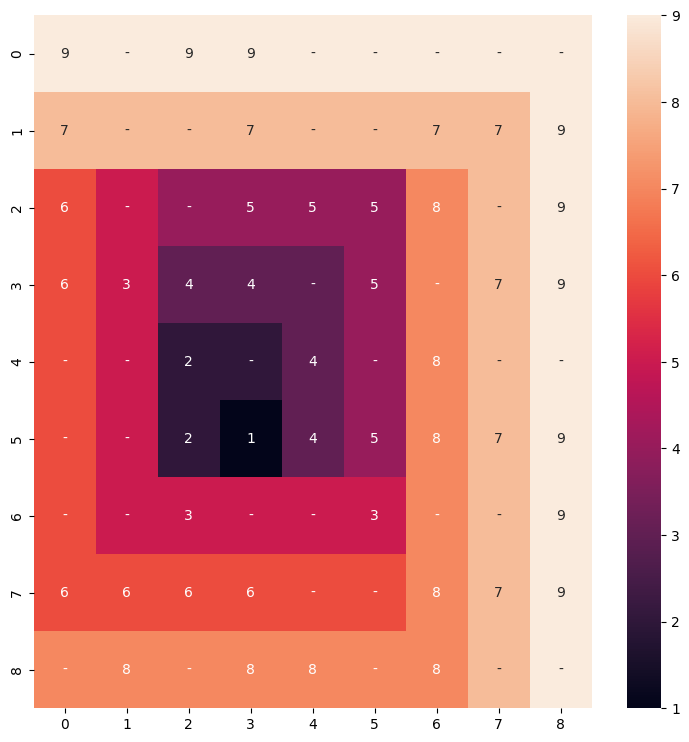

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
x = np.array((sol).astype(int)).astype(str)
x[x == "0"] = "-"
ax = sns.heatmap(region, annot=x, fmt="")
plt.show()